In [1]:
import pyusbus
 
import numpy as np 
import matplotlib.pyplot as plt

# Figures
import numpy as np
# Utilities
import json
import base64
import struct
import time 
import matplotlib.pyplot as plt
import cv2

import usb.core
import usb.util

In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Initialize the probe

In [2]:
probe = pyusbus.Doppler();

0
Reset done
Payloads sent


In [3]:
probe.payloads.keys()

dict_keys(['101', '247', '254', '256', '260', '263', '265', '267', '269', '498', '666', '8788', '_107', '_255', '_261', '_263', '_265', '_267', '_269', '_271', '_273', '_498', '_653', '_2814', '_6115', '_6387', '_7835', '_7839', '_7843', '_7847', '_7849', '_7851', '_16249', '_16251', '_18579', '_18581', '_20889', '_20894', '_22872', '_22874', '_29016', '_34489', '_34491', '_37965', '_37968'])

# Read a few frames and creates the loop

In [4]:
probe.getImages(n=3)
IMG = probe.createLoop()
np.shape(IMG)

(3, 128, 3584)

Text(0.5, 1.0, 'f')

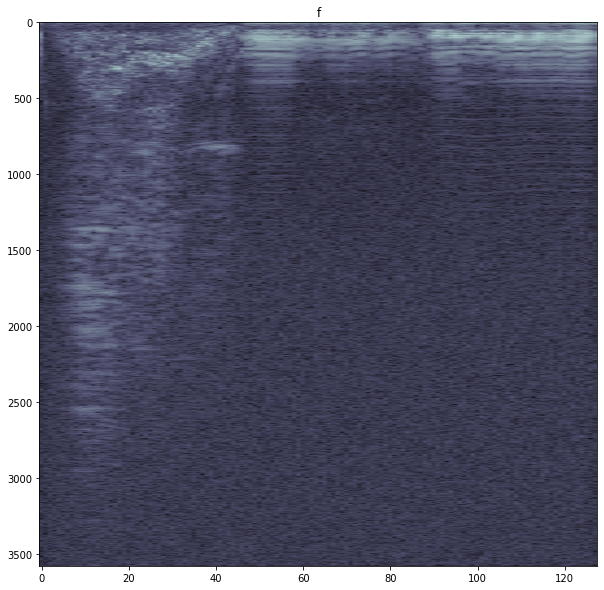

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(np.sqrt(np.abs(probe.loop[1])).T[7:]), aspect='auto', cmap='bone')
plt.title("f")

# Using now Doppler mode.
* Starts with startDoppler to setup the probe
* getImagesDoppler to get the images
* createLoopDoppler to actually process data to images

In [13]:
probe.startDoppler()

In [29]:
probe.getImagesDoppler(n=3)

1

In [30]:
probe.createLoopDoppler()

1

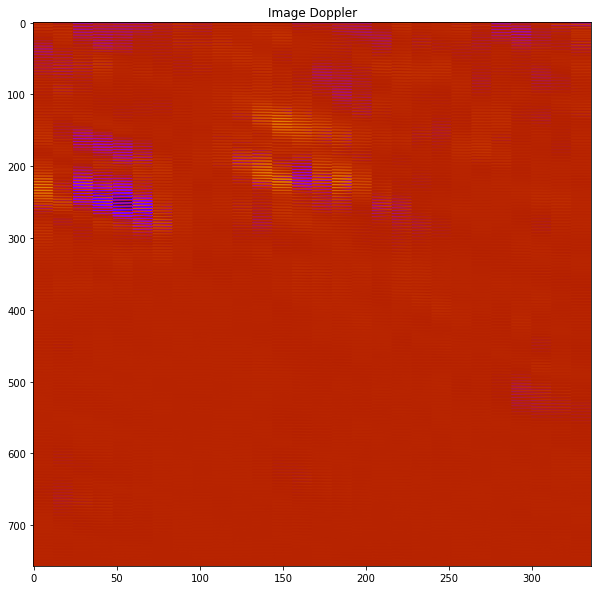

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(probe.dopplerDta[0], aspect='auto', cmap='gnuplot')
plt.title("Image Doppler")
plt.savefig("images/20211002/dopplerdirect.jpg")

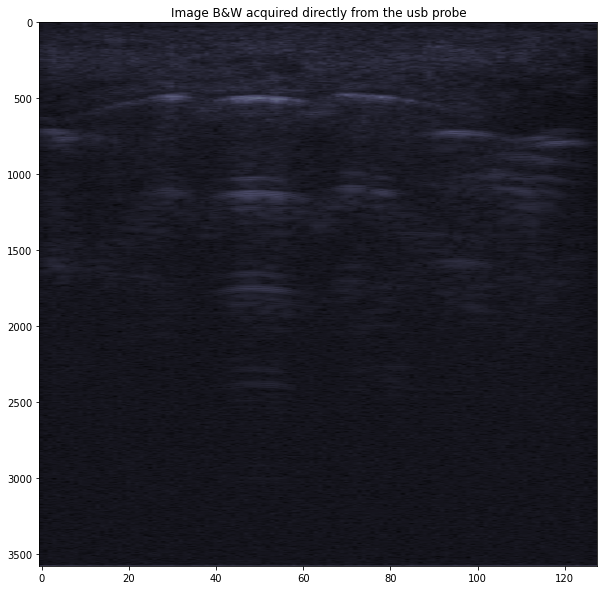

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(np.sqrt(np.abs(probe.loop[1])).T[7:]), aspect='auto', cmap='bone')
plt.title("Image B&W acquired directly from the usb probe")
plt.savefig("images/20211002/bwdirect.jpg")

# Other thinking around packets...

### Summary of packets

* 101 : [0 0 0 0 0 0 0 0 __4__  0 6 0 __0__ 0 0 0]. CMD 4. OFF. Could this be a __reset__?
* 247 : [0 0 0 0 0 0 0 0 __9__  0 6 0 __1__ 0 0 0]. CMD 9. ON.
* 254 : CMD2: as 256. a bit similar. Values not in order though.
* 256 : CMD3: could be a gain line. Still, 128 values indicated, may hint at something to do with number of lines?
* 260 : CMD4: 16 to 40 values. 24 spots. 24 is 8x3. 
* 263 : CMD5: Seems to be again a table.  Values in [value, register] order.
* 265 : CMD6: Command 6.
* 267 : CMD1: Same for 256 values. 
* 269 : [0 0 0 0 0 0 0 0 __1__  0 6 0 __0__ 0 0 0]. CMD 1. __Unfreeze__?.
  * Alone after 8788, renables EP, but nothings comes out of it.
* 498 : [0 0 0 0 0 0 0 0 __47__ 0 7 0 __8__ 0 0 0]. Commande 47 : commence par un 7 au lieu de 6. Pourquoi??
  * Always used only once at boot
* 666 : [0 0 0 0 0 0 0 0 __9__  0 6 0 __0__ 0 0 0]. CMD 9. Off.
* 8788: [0 0 0 0 0 0 0 0 __1__  0 6 0 __1__ 0 0 0]. CMD 1. __Freeze__?  
 

# Packets

In [61]:
for k in [101, 247, 254, 256, 260, 263, 265, 267, 269, 498, 666, 8788]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '>'+str(len(PL)//1)+'B', PL ) ) , 'b')
    print(k,len(PL))

101 512
247 512
254 1024
256 1024
260 512
263 1024
265 2560
267 1536
269 512
498 512
666 512
8788 512


In [29]:
for k in [101, 247, 254, 256, 260, 263, 265, 267, 269, 498, 666, 8788]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '>'+str(len(PL)//1)+'B', PL ) ) , 'b')
    pl = pl[4:-4] # trimming 165 165  90  90  //   90  90 165 165
    if (pl[:2] == pl[-4:-2]).all():
        print("Yeah")
        pl = pl[4:-4]
    print(k,"\t",len(PL),"\t",pl)

Yeah
101 	 512 	 [0 0 0 0 0 0 0 0 4 0 6 0 0 0 0 0]
Yeah
247 	 512 	 [0 0 0 0 0 0 0 0 9 0 6 0 1 0 0 0]
Yeah
254 	 1024 	 [  0   0   0   0   0   0   0   0 100   0   1   0   0   0   0   0  36   0
   1   0  41   0   0   0  12   0   1   0   0   0   0   0   3   0   6   0
   1   0   0   0   9   0   1   0 248 255 255 255   1   0   1   0 240 158
   0   0   7   0   6   0  35  54 184 240   8   0   1   0 252   6   0   0
  23   0   1   0   3   0   0   0   1   0   7   0 255   0 255 255   8   0
   6   0  56  20 185 252   7   0   1   0  56   0   0   0   2   0   1   0
   0  10   0   0 101   0   1   0   0   0   0   0  37   0   1   0  16   0
   0   0  10   0   1   0 252 255 255 255  11   0   1   0 254 255 255 255
  13   0   1   0   0   0   0   0  14   0   1   0 254 255 255 255  15   0
   1   0 252 255 255 255  16   0   1   0 248 255 255 255  17   0   1   0
   9   0   0   0  18   0   1   0   5   0   0   0  19   0   1   0   2   0
   0   0  20   0   1   0   0   0   0   0  21   0   1   0   0   0   0   0
  22

## Remarks

```
* 269  : [0 0 0 0 0 0 0 0 __1__ 0  6 0 __0__ 0 0 0] ressemble à
* 8788 : [0 0 0 0 0 0 0 0 __1__ 0  6 0 __1__ 0 0 0]
  * Commande 1: freeze/unfreeze?
* 666  : [0 0 0 0 0 0 0 0 __9__ 0  6 0 __0__ 0 0 0] ressemble à 
* 247  : [0 0 0 0 0 0 0 0 __9__ 0  6 0 __1__ 0 0 0]
  * Commande 9 ++ option ON/OFF ?
* 101  : [0 0 0 0 0 0 0 0 __4__ 0  6 0 __0__ 0 0 0]
  * Commande 4: qu'est ce qu'on a désactivé?
* 498:   [0 0 0 0 0 0 0 0 __47__ 0 7 0 __8__ 0 0 0]
  * Commande 47 : commence par un 7 au lieu de 6. Pourquoi??
```

### Restent les packets
 * [254, 256, 260, 263, 265, 267, 498]

In [46]:
for k in [254, 256, 260, 263, 265, 267]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '>'+str(len(PL)//1)+'B', PL ) ) , 'b')
    pl = pl[4:-4] # trimming 165 165  90  90  //   90  90 165 165
    if (pl[:2] == pl[-4:-2]).all():
        print("Yeah")
        pl = pl[4:-4]
    print(k,"\t",len(PL),"\t",pl)

Yeah
254 	 1024 	 [  0   0   0   0   0   0   0   0 100   0   1   0   0   0   0   0  36   0
   1   0  41   0   0   0  12   0   1   0   0   0   0   0   3   0   6   0
   1   0   0   0   9   0   1   0 248 255 255 255   1   0   1   0 240 158
   0   0   7   0   6   0  35  54 184 240   8   0   1   0 252   6   0   0
  23   0   1   0   3   0   0   0   1   0   7   0 255   0 255 255   8   0
   6   0  56  20 185 252   7   0   1   0  56   0   0   0   2   0   1   0
   0  10   0   0 101   0   1   0   0   0   0   0  37   0   1   0  16   0
   0   0  10   0   1   0 252 255 255 255  11   0   1   0 254 255 255 255
  13   0   1   0   0   0   0   0  14   0   1   0 254 255 255 255  15   0
   1   0 252 255 255 255  16   0   1   0 248 255 255 255  17   0   1   0
   9   0   0   0  18   0   1   0   5   0   0   0  19   0   1   0   2   0
   0   0  20   0   1   0   0   0   0   0  21   0   1   0   0   0   0   0
  22   0   1   0   1   0   0   0  24   0   1   0   7   0   0   0   3   0
   1   0  22   0   0   0   4   0 

In [60]:
for k in [254,256]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '<'+str(len(PL)//2)+'H', PL ) ) , 'b') 

    print(k,"\t",len(PL),"\t",pl)

254 	 1024 	 [42405 23130     2 23130     0     0     0     0   100     1     0     0
    36     1    41     0    12     1     0     0     3     6     1     0
     9     1 65528 65535     1     1 40688     0     7     6 13859 61624
     8     1  1788     0    23     1     3     0     1     7   255 65535
     8     6  5176 64697     7     1    56     0     2     1  2560     0
   101     1     0     0    37     1    16     0    10     1 65532 65535
    11     1 65534 65535    13     1     0     0    14     1 65534 65535
    15     1 65532 65535    16     1 65528 65535    17     1     9     0
    18     1     5     0    19     1     2     0    20     1     0     0
    21     1     0     0    22     1     1     0    24     1     7     0
     3     1    22     0     4     1     1     0     5     1    11     0
    98     1     0     0    34     1 64918 27103    99     1     0     0
    35     1  6096     0   106     1     0     0     5     6 18180 51436
     6     6 18448 56778   128     1  

## Comments:

* 256 could be a gain line. Still, 128 values indicated, may hint at something to do with number of lines?
* 254 a bit similar. Values not in order though.

In [49]:
for k in [263, 265, 267]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '<'+str(len(PL)//2)+'H', PL ) ) , 'b')


    print(k,"\t",len(PL),"\t",pl)

263 	 1024 	 [42405 23130     5 23130     0     0     0     0  4369     0  4369     1
  8465     2  8738     3  8738     4 17442     5 17476     6 17476     7
 17476     8 17476     9 17476    10 17476    11 17476    12 17476    13
 17476    14 17476    15 17476    16 17476    17 17476    18 17476    19
 17476    20 17476    21 17476    22 17476    23 17476    24 17476    25
 17476    26 17476    27 17476    28 17476    29 17476    30 17476    31
 17476    32 17476    33 17476    34 17476    35 17476    36 17476    37
 17476    38 17476    39 17476    40 17476    41 17476    42 17476    43
 17476    44 17476    45 17476    46 17476    47 17476    48 17476    49
 17476    50 17476    51 17476    52 17476    53 17476    54 17476    55
 17476    56 17476    57 17476    58 17476    59 17476    60 17476    61
 17476    62 17476    63  8738    64  8738    65  4642    66  4369    67
  4369    68 17425    69 17476    70 17476    71 17476    72 17476    73
 17476    74 17476    75 17476    76 1

* 263: Seems to be again a table. Command 5. Values in [value, register] order.
* 267: Same for 256 values. On command 1.
* 265: Command 6.

# 260 seems to be 16 to 40 values. 24 spots. 24 is 8x3. Why?

In [58]:
for k in [260]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '<'+str(len(PL)//2)+'H', PL ) ) , 'b')


    print(k,"\t",len(PL),"\t",pl)

260 	 512 	 [42405 23130     4 23130     0     0     0     0    60    16  1039    17
  1295    18 65280    19  2048    20  2305    21  3328    22  3599    23
  3840    24  4128    25  4358    26  4616    27  5121    28  5376    29
  5635    30  6147    31  6485    32  6661    33  6997    34  7173    35
  8448    36  8704    37 11079    38 11264    39 11520    40 65281    41
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     4 42405 23130 42405]


In [50]:
for k in [265]:
    PL = probe.payloads[str(k)]
    pl = np.trim_zeros(np.array( struct.unpack( '<'+str(len(PL)//2)+'H', PL ) ) , 'b')


    print(k,"\t",len(PL),"\t",pl)

265 	 2560 	 [42405 23130     6 ... 42405 23130 42405]


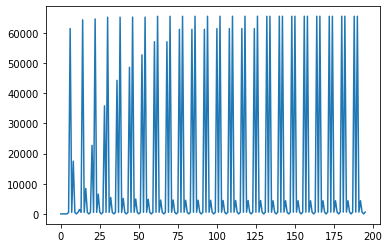

In [53]:
plt.plot(pl[4:200])